In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import pandas as pd
#创建NgSpiceShared对象
ngspice = NgSpiceShared.new_instance()
#读取电路文件
with open('mypdn.cir') as f:
    circuit=f.read()
#导入电路
ngspice.load_circuit(circuit)

In [28]:
#读取数据
core1_powers=pd.read_csv('./data/per_core_power_file_3.txt',header=None)
core2_powers=pd.read_csv('./data/per_core_power_file_4.txt',header=None)
core3_powers=pd.read_csv('./data/per_core_power_file_5.txt',header=None)
core4_powers=pd.read_csv('./data/per_core_power_file_6.txt',header=None)
cores_powers=[core1_powers,core2_powers,core3_powers,core4_powers]
for core_power in cores_powers:
    #加入表头
    core_power.columns=['Time','Power']
    #将时间转换为以ns为单位
    core_power['Time']=core_power['Time'].multiply(1000000000)
#print(cores_powers[0].head())
#print(cores_powers[0].Time)
cores_resistance=cores_powers
voltage_supply=1
resistance_number=9
for core_resistance in cores_resistance:
    core_resistance.columns=['Time','Resistance']
    #将功率转换为单个负载的电阻阻值
    core_resistance['Resistance']=core_resistance['Resistance'].str.slice(1,-2).astype(float)
    #print(core_resistance.head())
    core_resistance['Resistance']=resistance_number*voltage_supply*voltage_supply/core_resistance['Resistance']
print(cores_resistance[0].head())

       Time  Resistance
0  1.025641   31.824611
1  2.051282   31.824611
2  3.076923   31.824611
3  4.102564   31.824611
4  5.128205   31.824611


1 : condition met: stop  when time = 1.02564e-09
doAnalyses: pause requested
tran simulation interrupted
2 : condition met: stop  when time = 2.05128e-09
doAnalyses: pause requested
simulation interrupted
3 : condition met: stop  when time = 3.07692e-09
doAnalyses: pause requested
simulation interrupted
4 : condition met: stop  when time = 4.10256e-09
doAnalyses: pause requested
simulation interrupted
5 : condition met: stop  when time = 5.12821e-09
doAnalyses: pause requested
simulation interrupted
6 : condition met: stop  when time = 6.15385e-09
doAnalyses: pause requested
simulation interrupted
7 : condition met: stop  when time = 7.17949e-09
doAnalyses: pause requested
simulation interrupted
8 : condition met: stop  when time = 8.20513e-09
doAnalyses: pause requested
simulation interrupted
9 : condition met: stop  when time = 9.23077e-09
doAnalyses: pause requested
simulation interrupted
10: condition met: stop  when time = 1.02564e-08
doAnalyses: pause requested
simulation interru

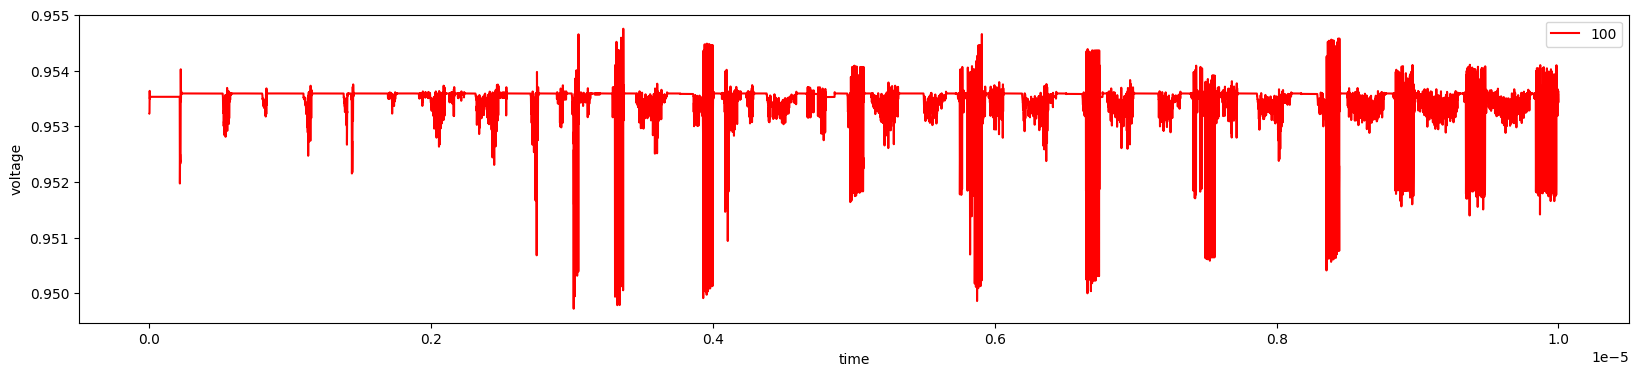

In [ ]:
#参数设置
step_time='100p'
end_time='10u'
stop_number=10000
stop_time=cores_resistance[0].loc[:stop_number,'Time']
#根据spice的断点执行规则，
# 1、首先设置好仿真时的断点时间
# 2、开始仿真
# 3、在仿真中途会在设置好的时间中断仿真，此时可以进行一些指令，最后执行resume指令继续仿真，直到下一个断点或终点

#设置断点，每100ns设置一个断点
for i in range(stop_number):
    ngspice.stop('time = '+str(stop_time[i])+'n')

#开始仿真
#由于pyspice总是在stop时报错command error，但实际没有问题，所以使用try except保证后续代码继续执行
try:
    ngspice.exec_command('tran '+step_time+' '+end_time)
except:
    pass

#当中断时执行的指令
for i in range(stop_number):
    #更换负载
    if cores_resistance[0].loc[i,'Resistance'] == float('inf'):
        ngspice.alter_device('r1000000001_1000000002',resistance=10000000000)
    else:
        ngspice.alter_device('r1000000001_1000000002',resistance=cores_resistance[0].loc[i,'Resistance'])
    
    #由于pyspice总是在stop时报错command error，所以使用try except保证后续代码继续执行
    try:
        ngspice.resume(background=False)
    except:
        pass

#获取仿真结果
plots = ngspice.plot(simulation=None, plot_name=ngspice.last_plot)
analysis=plots.to_analysis()
#绘制图像
fig=plt.figure(figsize=(20,4))
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100.png",dpi=300)
plt.close()

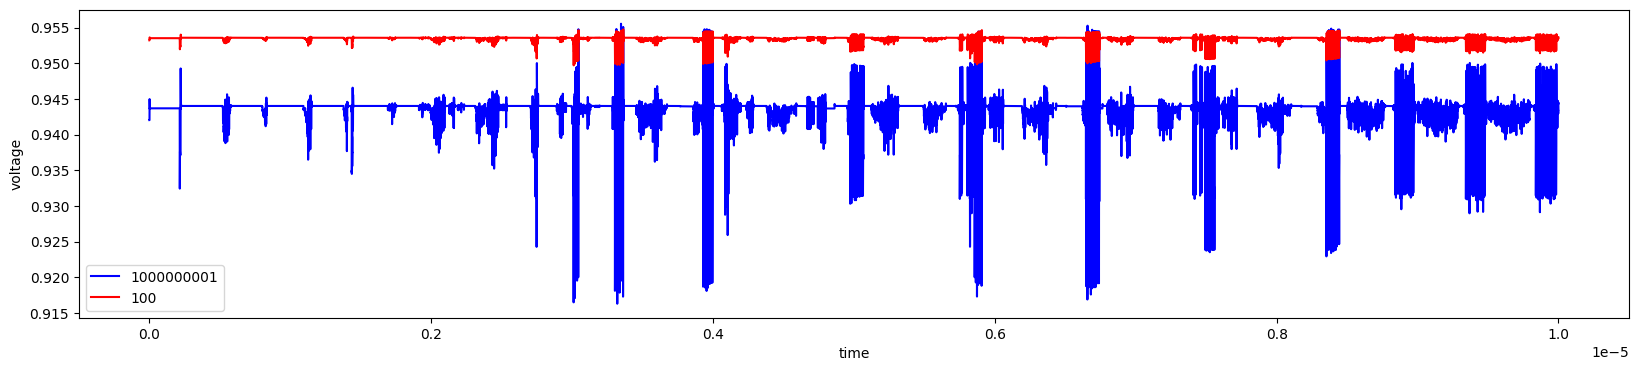

In [35]:
fig=plt.figure(figsize=(20,4))
#plt.plot(np.array(analysis.time),np.array(analysis["1000000002"]), label="1000000002",color='black')
plt.plot(np.array(analysis.time),np.array(analysis["1000000001"]), label="1000000001",color='blue')
plt.plot(np.array(analysis.time),np.array(analysis["100"]), label="100",color='red')
plt.legend()
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()
fig.savefig("./figure/V100-V1000000001.png",dpi=300)